> Our stories usually start with a line like:
>
> $  \forall \epsilon > 0 , \exists \delta > 0 \; ... $
> 
> But this time, we proudly start it with
> ```py
> import torch_geometric
> ```

Our blog post: https://medium.com/@nm8144/a7a40caeb959

Account name: Nina Mislej - @nm8144

Authors: Nina Mislej, Aljaž Medič, Aleks Stepančič, Luka Sabotič

In [3]:
# Install dependencies
%pip install torch-geometric
%pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
%pip install seaborn optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import dependencies, check versions
import torch_geometric
import pandas as pd
import torch
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple, Union, Optional
import seaborn as sns
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
sns.set_theme()

print(torch.__version__)
print(torch_geometric.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)


1.13.1
2.2.0
Running on cuda


# Dataset

We used elliptic dataset from [Kaggle](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set?resource=download).

> The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.).
> The task on the dataset is to classify the illicit and licit nodes in the graph.

In [4]:
# Dataset loading

# Uncomment the following line for local execution
# os.environ['DATASET_PATH'] = r'\dataset\elliptic_bitcoin_dataset'

is_running_from_local = 'DATASET_PATH' in os.environ
if is_running_from_local:
    print('DATA_PATH: ', os.environ['DATASET_PATH'])
    DATASET_PATH = os.environ['DATASET_PATH']
else:
    print("Reading from Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive')  # Check: !ls drive/MyDrive/
    DATASET_PATH = 'drive/MyDrive/elliptic_bitcoin_dataset/'
    print('DATA_PATH: ', DATASET_PATH)

classes = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_classes.csv", index_col="txId")
edgelist = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_edgelist.csv")

# index on the top level timestamp, second level txId
features = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_features.csv", header=None, index_col=[1, 0])
features.index.names = ['timestamp', 'txId']

# That way, features are sorted by timestamp, as sample of first 5 columns shows:
display(features.loc[:, :5])

Reading from Google Drive...
Mounted at /content/drive
DATA_PATH:  drive/MyDrive/elliptic_bitcoin_dataset/


2         3         4          5
timestamp txId                                              
1         230425980 -0.171469 -0.184668 -1.201369  -0.121970
          5530458   -0.171484 -0.184668 -1.201369  -0.121970
          232022460 -0.172107 -0.184668 -1.201369  -0.121970
          232438397  0.163054  1.963790 -0.646376  12.409294
          230460314  1.011523 -0.081127 -1.201369   1.153668
...                       ...       ...       ...        ...
49        173077460 -0.145771 -0.163752  0.463609  -0.121970
          158577750 -0.165920 -0.123607  1.018602  -0.121970
          158375402 -0.172014 -0.078182  1.018602   0.028105
          158654197 -0.172842 -0.176622  1.018602  -0.121970
          157597225 -0.012037 -0.132276  0.463609  -0.121970

[203769 rows x 4 columns]

In [5]:
# Defining target classes

# We want to have directed graphs
directed_graph = nx.from_pandas_edgelist(
    edgelist, source='txId1', target='txId2', create_using=nx.DiGraph())


ID_ILLICIT = 0  # Fraud
ID_LICIT = 1  # Legitimate
ID_UNLABELED = 2 # Unknown

# We have to construct mappings from node ids to features and classes
# Then, we can use them to set node attributes in the subgraphs

classes['y'] = classes['class'].replace(
    {'unknown': ID_UNLABELED, '1': ID_ILLICIT, '2': ID_LICIT})
class_mapping = classes[['y']].to_dict("dict")['y']

keys = features.index.get_level_values(1)
rows = torch.tensor(features.values, dtype=torch.double)
feature_mapping = dict(zip(keys, rows))


timestamps = features.index.get_level_values(
    0).unique().sort_values().to_list()
ts_TxID_df = features.index.to_frame(index=False)

# We want to 
dataset: List[nx.DiGraph] = []
for ts in timestamps:
    # Get all txIds for a given timestamp
    sub_graph_idx = ts_TxID_df[ts_TxID_df.timestamp == ts].txId.to_list()
    # Create subgraph from the original graph
    s = directed_graph.subgraph(sub_graph_idx)
    nx.set_node_attributes(s, class_mapping, "y")
    nx.set_node_attributes(s, feature_mapping, "x")

    dataset.append(s)

# Takes ~40sec to run

## Statistical overview of the data


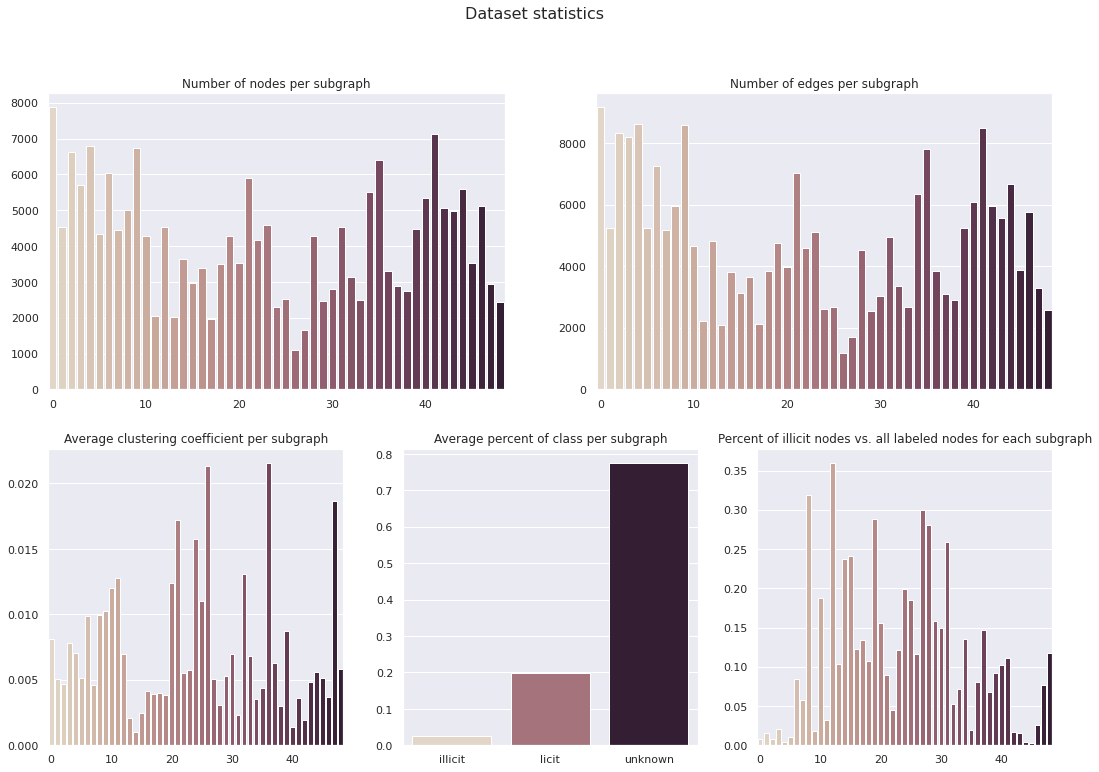

In [6]:
# Statistical data of the dataset

subgraph_nodes = np.array([len(subgraph.nodes) for subgraph in dataset])
subgraph_edges = np.array([len(subgraph.edges) for subgraph in dataset])

subgraph_idx = np.arange(len(dataset))
x_ticks = np.arange(0, len(dataset), 10)

plt.figure(figsize=(18, 12))

plt.subplot(221)
plt.title("Number of nodes per subgraph")
sns.barplot(x=subgraph_idx, y=subgraph_nodes, palette="ch:.25")
plt.xticks(x_ticks)

plt.subplot(222)
plt.title("Number of edges per subgraph")
sns.barplot(x=subgraph_idx, y=subgraph_edges, palette="ch:.25")
plt.xticks(x_ticks)

avg_cluster_coef = np.array([nx.average_clustering(subgraph)
                            for subgraph in dataset])


def graph_bincount(G):
    bc = np.bincount([attrs["y"] for _, attrs in G.nodes(data=True)])
    return bc / bc.sum()


no_of_classes = np.array([graph_bincount(subgraph) for subgraph in dataset])

avg_node_class = np.mean(no_of_classes, axis=0)
illicit_percentage = [x_ill / (x_ill + x_lic)
                      for x_ill, x_lic, _ in no_of_classes]


plt.subplot(234)
plt.title("Average clustering coefficient per subgraph")
sns.barplot(x=subgraph_idx, y=avg_cluster_coef, palette="ch:.25")
plt.xticks(np.arange(0, len(dataset), 10))


plt.subplot(235)
plt.title("Average percent of class per subgraph")
sns.barplot(x=["illicit", "licit", "unknown"],
            y=avg_node_class, palette="ch:.25")

plt.subplot(236)
plt.title("Percent of illicit nodes vs. all labeled nodes for each subgraph")
sns.barplot(x=subgraph_idx, y=illicit_percentage, palette="ch:.25")
plt.xticks(np.arange(0, len(dataset), 10))

plt.suptitle("Dataset statistics", fontsize=16)

pass


/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


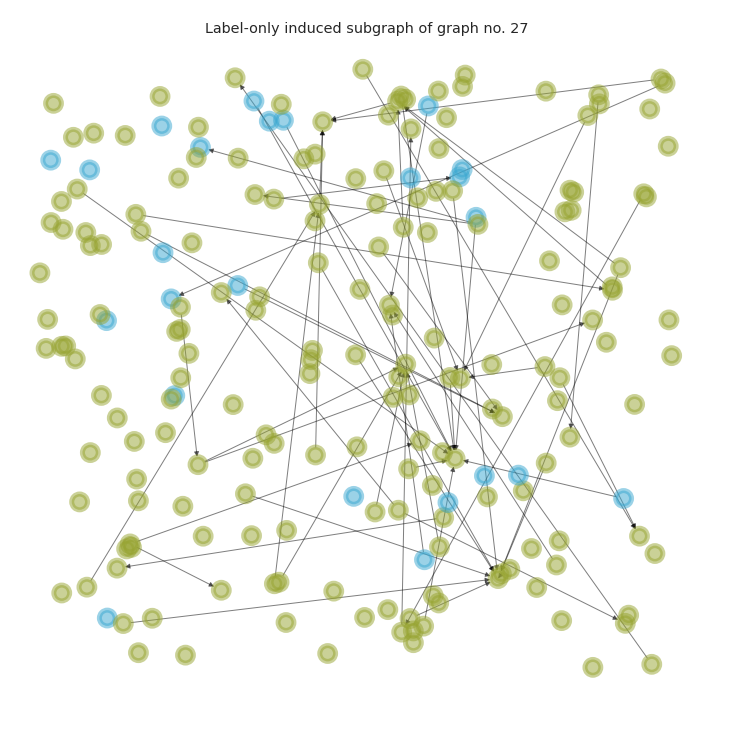

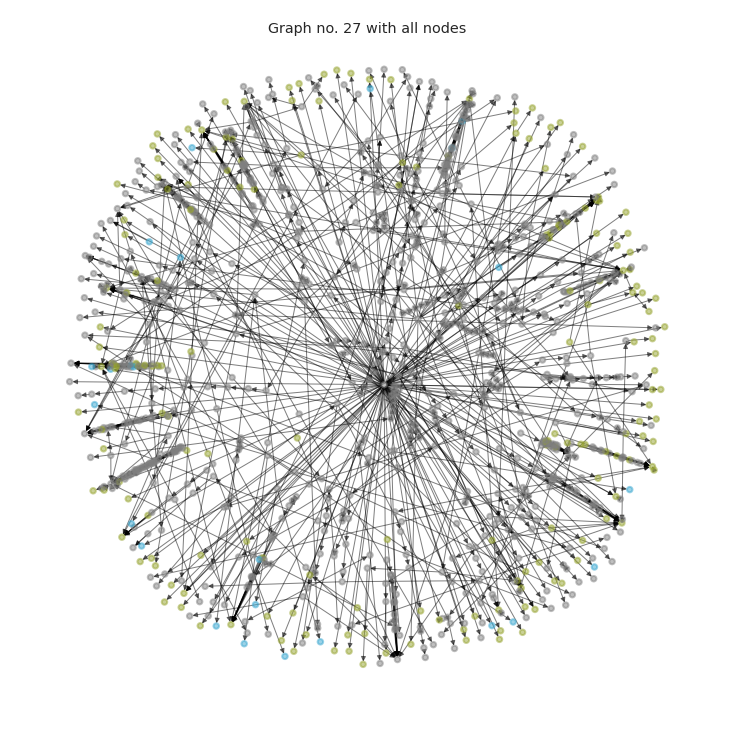

In [7]:
# Displaying the smallest subgraph
min_idx = np.argmin(subgraph_nodes)
smallest_subgraph = dataset[min_idx]
labeled_nodes = [x for x, y in smallest_subgraph.nodes(data=True) if y['y']!=ID_UNLABELED]
labeled_graph = nx.induced_subgraph(smallest_subgraph, labeled_nodes)

palette = sns.color_palette("husl", 8)
color_map = {ID_UNLABELED: "gray", ID_LICIT: palette[2], ID_ILLICIT: palette[5]}
colors_labled = [color_map[attrs["y"]] for _, attrs in labeled_graph.nodes(data=True)]
colors_full = [color_map[attrs["y"]] for _, attrs in smallest_subgraph.nodes(data=True)]

plt.figure(figsize=(10,10)) 
nx.draw_random(labeled_graph, node_color=colors_labled, node_size=250, linewidths=5, edge_color="black", alpha=0.5)
plt.suptitle(f"Label-only induced subgraph of graph no. {min_idx+1}")

plt.figure(figsize=(10,10))
pos = nx.spring_layout(smallest_subgraph, center=None, dim=2, seed=1)
nx.draw(smallest_subgraph, pos=pos, node_color=colors_full, node_size=30, linewidths=2, edge_color="black", alpha=0.5)
plt.suptitle(f"Graph no. {min_idx+1} with all nodes")
pass

# Model Definition

The Model is defined in the following cell. It is highly modular, as it can work with two different types of convolutional layers: `GCNConv` and `GATConv`. It also supports different hidden channel sizes, different numbers of hidden layers, different dropout and nonlinearity function.

In [8]:
# Model definition
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
import torch.nn as nn
import torch.nn.functional as F


class SM2GNN(torch.nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_channels: int,
                 conv_model: type[nn.Module],
                 nonlinearity: nn.Module,
                 num_hidden: int = 3,
                 conv_args: Dict = {},
                 dropout: float = 0.5):
        super(SM2GNN, self).__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(
            conv_model(in_channels, hidden_channels, **conv_args)
        )
        self.bns.append(BatchNorm(hidden_channels))
        for _ in range(num_hidden):
            self.convs.append(
                conv_model(hidden_channels, hidden_channels, **conv_args))
            self.bns.append(BatchNorm(hidden_channels))

        self.convs.append(
            conv_model(hidden_channels, out_channels, **conv_args))
        self.bns.append(BatchNorm(hidden_channels))

        self.dropout = dropout
        self.nonlinearity = nonlinearity

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index, return_embeddings: bool = False):
        for i in range(len(self.convs)-1):
            conv = self.convs[i]
            x = conv(x, edge_index)
            x = self.nonlinearity(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.bns[i](x)

        if not return_embeddings:
            x = self.convs[len(self.convs)-1](x, edge_index)
            x = F.softmax(x, dim=1)
        return x


## Model Configuration

Because we want to fine-tune hyper parameters of the model, we define `ModelConfig`, that will be json serializable, and will be used to create `SM2GNN` instance. Similarly, there are some other configuration options for training:
 - How many epochs we want to train for?
 - What will be our batch size?
 - What optimizer we want to use? Which parameters should we use for it?
 - What loss function we want to use?

We used `dataclasses` library, that allows us to define classes with default values, and then easily convert them to json.

In [9]:
# Model Config
from dataclasses import dataclass, asdict, field

import json
import re


class SerializableConfig:

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self

    @classmethod
    def from_dict(cls, d: dict):
        # only take the keys that are in the dataclass
        d = {k: v for k, v in d.items() if k in cls.__dataclass_fields__}
        return cls(**d)

    def update_keys(self, **kwargs: dict):
        d = {k: v for k, v in kwargs.items() if k in self.__dataclass_fields__}
        for k, v in d.items():
            setattr(self, k, v)
        return self


@dataclass
class ModelConfig(SerializableConfig):
    in_channels: int = -1
    hidden_channels: int = 64
    out_channels: int = 2
    num_hidden: int = 3
    conv_model: str = "GATConv(4)"
    conv_args: dict = field(default_factory=dict)
    dropout: float = 0.5
    nonlinearity: str = 'leaky_relu(0.2)'

    def __nonlinearity(self):
        if self.nonlinearity == 'relu':
            return nn.ReLU()
        leakyrelu_re = re.match(
            r'leaky_relu\((\d+\.?\d*)\)', self.nonlinearity)
        if leakyrelu_re:
            return nn.LeakyReLU(float(leakyrelu_re.group(1)))
        if self.nonlinearity == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unknown nonlinearity: {self.nonlinearity}")

    def __model_type(self):
        gatconv_re = re.match(r'GATConv\((\d+)\)', self.conv_model)
        if gatconv_re:
            heads = int(gatconv_re.group(1))
            self.conv_args.update({"concat": False, "heads": heads})
            return GATConv
        elif self.conv_model == "GCNConv":
            return GCNConv
        else:
            raise ValueError(f"Unknown model type: {self.conv_model}")

    def create(self):
        return SM2GNN(in_channels=self.in_channels,
                       hidden_channels=self.hidden_channels,
                       out_channels=self.out_channels,
                       num_hidden=self.num_hidden,
                       conv_model=self.__model_type(),
                       conv_args=self.conv_args, dropout=self.dropout,
                       nonlinearity=self.__nonlinearity()
                       ).to(device)


`TrainConfig` class defines the training configuration. It also contains a hyperparameter for class weight, which helps to reduce the impact of the imbalanced dataset.

In [10]:
# Train Config

@dataclass
class TrainConfig(SerializableConfig):
    num_epoch: int = 10
    batch_size: int = 32
    test_split: float = 0.2
    random_state: Optional[int] = None

    # Optimizer
    optimizer_name: str = 'adam'
    lr: float = 0.01
    weight_decay: float = 5e-4

    def get_optimizer_for(self, model):
        if self.optimizer_name == 'adam':
            return torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name == 'sgd':
            return torch.optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unknown optimizer name: {self.optimizer_name}")

    # Loss function
    loss_name: str = 'cross_entropy'

    # Beacuse of the class imbalance, we want to give more weight to the ID_LICIT class
    class_weight: float = 0.80

    def get_loss(self):
        class_weights = torch.tensor(
            [self.class_weight, 1 - self.class_weight], device=device)
        if self.loss_name == 'cross_entropy':
            return torch.nn.CrossEntropyLoss(weight=class_weights)
        if self.loss_name == 'bce':
            return torch.nn.BCEWithLogitsLoss(weight=class_weights)
        else:
            raise ValueError(f"Unknown loss name: {self.loss_name}")


# The Pipeline

## Data splitting

We have to transform our graphs from `networkx` to `torch_geometric` format. We also have to split the data into train and test sets. We use `train_test_split` function from `sklearn` to do that.

In [11]:
# Data loaders
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split

def split_and_create_loaders(config: TrainConfig, dataset: List[nx.Graph]) -> Tuple[Tuple[List, List], Tuple[DataLoader, DataLoader]]:
    X_graphs = []
    for subgraph in dataset:
        _x = from_networkx(subgraph)
        X_graphs.append(_x)
    X_train, X_test = train_test_split(
        X_graphs, test_size=config.test_split, random_state=config.random_state)
    train_loader = DataLoader(
        X_train, batch_size=config.batch_size)
    test_loader = DataLoader(X_test, batch_size=1)
    return (X_train, X_test), (train_loader, test_loader)


## Training

In [12]:
# Train
from tqdm.notebook import trange, tqdm


# Utility function for making log one line log, with updated best loss
def log(epoch, loss, best, one_line: bool = False):
    if loss < best[1]:
        best = (epoch, loss)
    best_epoch, best_loss = best
    s = f"Epoch: {epoch} | Loss: {loss:.4f} | Best loss: {best_loss:.4f} @ Epoch {best_epoch}"
    s = f"\r{s}" if one_line else f"{s}\n"
    tqdm.write(s, end="")


def train(model: SM2GNN, data_loader: DataLoader, config: TrainConfig, one_line_log: bool = False):
    best_tuple = (-1, np.inf)
    dataset = data_loader.dataset
    loss_fn = config.get_loss()
    optimizer = config.get_optimizer_for(model)
    model.to(device)
    model.reset_parameters()
    model.train()
    for epoch in trange(config.num_epoch, unit="Epochs", desc="Training"):

        epoch_loss = 0
        for batch in data_loader:
            optimizer.zero_grad()
            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            label_mask = (batch.y != ID_UNLABELED)
            loss = loss_fn(out[label_mask],
                           batch.y[label_mask])
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.num_graphs
        avg_epoch_loss = epoch_loss / len(dataset)
        log(epoch, avg_epoch_loss, best_tuple, one_line=one_line_log)
    print()


## Testing

Testing method is very similar to training method, but it does not update the model parameters. It also does not use `DataLoader`, as we want to get the predictions for all the nodes in the graph, but the difference is, that our model wasn't trained on the data in this set. That way, we can measure the performance of the model on the data it has never seen before.

The method also has a parameter `in_kfold`, that is used when we are doing cross-validation. If we are doing cross-validation, we don't want to do any extensive analysis, such as ROC curve, but rather only compute f1_score.

Notice, the `@torch.no_grad()` decorator. It is used to tell PyTorch, that we don't want to compute gradients for this method, because we do not need them.

In [13]:
# Test
from sklearn.metrics import accuracy_score, f1_score, roc_curve


@torch.no_grad()
def test(model: SM2GNN, data_loader: DataLoader,
         in_kfold: bool = False):
    model.to(device)
    model.eval()

    all_y = np.array([])
    all_predicted = np.array([])
    all_predicted_is_1 = np.array([])

    for batch in tqdm(data_loader, unit="Test cases", desc="Testing"):
        batch.to(device)
        y_pred = model(batch.x.float(), batch.edge_index).to('cpu')
        batch.to('cpu')

        label_mask = batch.y != ID_UNLABELED
        y_true = batch.y[label_mask].numpy()
        y_pred = y_pred[label_mask]
        y_pred_arg = y_pred.argmax(dim=1).numpy()

        all_predicted = np.append(all_predicted, y_pred_arg)
        all_y = np.append(all_y, y_true)
        if not in_kfold:
            # Compute ROC curve and ROC area for class 1 = ID_LICIT
            predicted_is_1 = y_pred[:, 1].numpy()
            all_predicted_is_1 = np.append(all_predicted_is_1, predicted_is_1)

            acc = accuracy_score(y_true, y_pred_arg)
            f1 = f1_score(y_true, y_pred_arg, average="macro")
            print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

    all_f1 = f1_score(all_y, all_predicted, average="macro")

    if not in_kfold:
        acc = accuracy_score(all_y, all_predicted)
        f1 = f1_score(all_y, all_predicted, average="macro")
        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")
        print(
            f"True ratio of licit nodes: {(all_y == ID_LICIT).sum()/len(all_y)}",
            f"Ratio of predicted licit nodes: {(all_predicted == ID_LICIT).sum()/len(all_predicted)}", sep="\n")
        fpr, tpr, _ = roc_curve(all_y, all_predicted_is_1)
        plt.plot(fpr, tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    return all_f1


# Instantiating the model

## Local config

First, we can try and run the model with default configuration. You are welcome to change the configuration (located in .json files), and see how it affects the performance of the model. By default, model configuration is stored in `local_model_config.json` and
training configuration is stored in `local_train_config.json`.

Training:   0%|          | 0/10 [00:00<?, ?Epochs/s]

Epoch: 9 | Loss: 0.4783 | Best loss: 0.4783 @ Epoch 9
Base-predictor, with some default hyper-parameter values


Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

Accuracy: 0.8491, F1: 0.7176
Accuracy: 0.8738, F1: 0.8056
Accuracy: 0.9274, F1: 0.7304
Accuracy: 0.9722, F1: 0.5384
Accuracy: 0.7496, F1: 0.5986
Accuracy: 0.8836, F1: 0.7827
Accuracy: 0.8662, F1: 0.7127
Accuracy: 0.9350, F1: 0.4832
Accuracy: 0.8508, F1: 0.5734
Accuracy: 0.8953, F1: 0.6055
Accuracy: 0.8830, F1: 0.6769
True ratio of licit nodes: 0.8804558159535584
Ratio of predicted licit nodes: 0.918297140399914


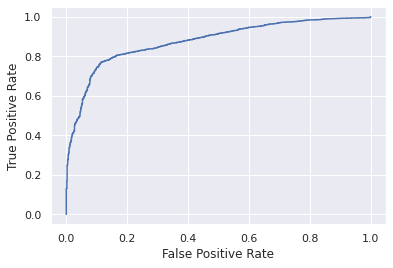

F1 score: 0.6769


In [14]:
# Local JSON configuration


fname = 'local_training_config.json'
try:
    config = TrainConfig.load(fname)
except FileNotFoundError:
    config = TrainConfig(
        num_epoch=10,
        batch_size=32,
        test_split=0.2,
        optimizer_name='adam',
        lr=0.01,
        weight_decay=5e-4,
        loss_name='cross_entropy'
    ).save(fname)

fname = 'local_model_config.json'
try:
    model_config = ModelConfig.load(fname)
except FileNotFoundError:
    model_config = ModelConfig(
        hidden_channels=64,
        num_hidden=3,
        conv_model='GATConv(2)',
        dropout=0.5,
        nonlinearity='leaky_relu(0.2)').save(fname)

model = model_config.create()

_, (loader_X_train, loader_X_test) = split_and_create_loaders(config, dataset)
train(model, loader_X_train, config, one_line_log=True)
print("Base-predictor, with some default hyper-parameter values")

f1 = test(model, loader_X_test)
print(f"F1 score: {f1:.4f}")


## K-fold cross-validation for hyper-parameter tuning

There are better ways of doing hyper-parameter tuning, then doing it by hand. We can use [Optuna](https://optuna.org/) to do it for us. Optuna is a hyper-parameter tuning library, that supports many different types of hyper-parameter tuning algorithms. We will use [TPE](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html) algorithm, which is a Bayesian optimization algorithm.

The catch is, we need to define a function, that will reliably quantify the performance of the model, (or rather performance of the hyper-parameters). In the process of optimization, optuna will provide a `trial` object, that will provide us with the hyper-parameters, we will create and validate or model with this hyper-parameters, then return the result. Optuna will then use this result to decide, which hyper-parameters to try next. 

To reduce variance in our model, we will use k-fold cross-validation. We will split the data into `k` folds, and then train the model `k` times, each time using different fold for validation, and the rest for training. We will then average the performance of the model on all the folds. That will be our metric.

It is worth noting, that the number of times, that our model will be trained, will be `k * n_trials * epochs`. So, if we have 5 folds, 20 trials, and 64 epochs, our model will be trained 6400 times. 

In [15]:
# K-Fold Cross Validation

from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import RepeatedKFold
from tqdm.notebook import tqdm


def kfold(model, config: TrainConfig, train_dataset:List, n_splits=5, n_repeats=1):
    f1_history = []
    rkfold_splitter = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

    for (train_idx, val_idx) in tqdm(rkfold_splitter.split(train_dataset), total=n_splits*n_repeats, desc="K-Fold"):
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(
            train_dataset, batch_size=config.batch_size, sampler=train_sampler)
        valid_loader = DataLoader(
            train_dataset, batch_size=config.batch_size, sampler=valid_sampler)
        train(model, train_loader, config, one_line_log=True)
        f1 = test(model, valid_loader, in_kfold=True)
        f1_history.append(f1)
    avg_test_f1 = np.mean(f1_history)
    print(f"Average F1: {avg_test_f1}")
    return avg_test_f1


In [17]:
# Hyperparameter search
import optuna
from optuna.samplers import TPESampler

N_TRIALS = 20

def objective(trial):
    global X_train, base_train_conf
    model_config = ModelConfig(
        hidden_channels=trial.suggest_int('hidden_channels', 2, 6),
        num_hidden=trial.suggest_int('num_hidden', 1, 4),
        conv_model=trial.suggest_categorical(
            'conv_model', ['GATConv(1)', 'GATConv(2)', 'GATConv(3)', 'GATConv(4)', 'GCNConv']),
        conv_args={},
        dropout=trial.suggest_float('dropout', 0.1, 0.5),
        nonlinearity=trial.suggest_categorical(
            'nonlinearity', ['relu', 'leaky_relu(0.2)', 'sigmoid'])
    )
    config = base_train_conf.update_keys(
        lr=trial.suggest_float('lr', 1e-4, 1e-1, log=True),
        weight_decay=trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True),
        class_weight=trial.suggest_float('class_weight', 0.6, 0.9, log=True)
    )
    model = model_config.create()
    return kfold(model, config, X_train, n_splits=5, n_repeats=1)


(X_train, _), (loader_X_train, loader_X_test) = split_and_create_loaders(config, dataset)
base_train_conf = TrainConfig(
    num_epoch=64,
    batch_size=8,
    test_split=0.2,  # Not used in kfold
    optimizer_name='adam',
    lr=1e-4,
    weight_decay=1e-5,
    loss_name='cross_entropy',
    class_weight=0.9
)
study = optuna.create_study(direction='maximize', sampler=TPESampler())
try:
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
except KeyboardInterrupt:
    pass
except Exception as e:
    print(e)


[I 2023-03-26 00:53:47,733] A new study created in memory with name: no-name-f4895a29-7e7a-4e62-99e2-deed821eb5bb


  0%|          | 0/20 [00:00<?, ?it/s]

K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3240 | Best loss: 0.3240 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3167 | Best loss: 0.3167 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3173 | Best loss: 0.3173 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3241 | Best loss: 0.3241 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3486 | Best loss: 0.3486 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.8050229835960678
[I 2023-03-26 00:54:27,111] Trial 0 finished with value: 0.8050229835960678 and parameters: {'hidden_channels': 3, 'num_hidden': 1, 'conv_model': 'GATConv(2)', 'dropout': 0.1756387005082564, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.014061001786285499, 'weight_decay': 0.00019033250020679288, 'class_weight': 0.6757793698217697}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4833 | Best loss: 0.4833 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5046 | Best loss: 0.5046 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5022 | Best loss: 0.5022 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4773 | Best loss: 0.4773 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4860 | Best loss: 0.4860 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.5835672462111876
[I 2023-03-26 00:55:17,160] Trial 1 finished with value: 0.5835672462111876 and parameters: {'hidden_channels': 2, 'num_hidden': 4, 'conv_model': 'GATConv(1)', 'dropout': 0.3317513267495553, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.00216727914450081, 'weight_decay': 0.024231106509107186, 'class_weight': 0.8393694720344731}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5103 | Best loss: 0.5103 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5080 | Best loss: 0.5080 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4945 | Best loss: 0.4945 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4845 | Best loss: 0.4845 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4937 | Best loss: 0.4937 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.5500740634251169
[I 2023-03-26 00:55:54,326] Trial 2 finished with value: 0.5500740634251169 and parameters: {'hidden_channels': 3, 'num_hidden': 2, 'conv_model': 'GCNConv', 'dropout': 0.393645246708328, 'nonlinearity': 'relu', 'lr': 0.0002596177551118075, 'weight_decay': 0.00042845063910544785, 'class_weight': 0.7587391737725576}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3684 | Best loss: 0.3684 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3771 | Best loss: 0.3771 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3727 | Best loss: 0.3727 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3792 | Best loss: 0.3792 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3942 | Best loss: 0.3942 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.4804377539175248
[I 2023-03-26 00:56:34,734] Trial 3 finished with value: 0.4804377539175248 and parameters: {'hidden_channels': 6, 'num_hidden': 3, 'conv_model': 'GCNConv', 'dropout': 0.17536396015692804, 'nonlinearity': 'sigmoid', 'lr': 0.0017230739376030816, 'weight_decay': 0.0029201801924565994, 'class_weight': 0.6103704175651736}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4590 | Best loss: 0.4590 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4663 | Best loss: 0.4663 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4746 | Best loss: 0.4746 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4955 | Best loss: 0.4955 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4971 | Best loss: 0.4971 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.6527982515135663
[I 2023-03-26 00:57:13,373] Trial 4 finished with value: 0.6527982515135663 and parameters: {'hidden_channels': 3, 'num_hidden': 1, 'conv_model': 'GATConv(2)', 'dropout': 0.3214771927491038, 'nonlinearity': 'sigmoid', 'lr': 0.0006039692355513586, 'weight_decay': 4.1247739181460046e-05, 'class_weight': 0.7964657511815498}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5088 | Best loss: 0.5088 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5303 | Best loss: 0.5303 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5021 | Best loss: 0.5021 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5279 | Best loss: 0.5279 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5776 | Best loss: 0.5776 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.472979039537028
[I 2023-03-26 00:57:50,859] Trial 5 finished with value: 0.472979039537028 and parameters: {'hidden_channels': 4, 'num_hidden': 2, 'conv_model': 'GCNConv', 'dropout': 0.19735844756802026, 'nonlinearity': 'relu', 'lr': 0.00012400301132408246, 'weight_decay': 5.974635013883002e-05, 'class_weight': 0.7548434111110413}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5257 | Best loss: 0.5257 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4443 | Best loss: 0.4443 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4116 | Best loss: 0.4116 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4128 | Best loss: 0.4128 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4381 | Best loss: 0.4381 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.691276877962822
[I 2023-03-26 00:58:36,675] Trial 6 finished with value: 0.691276877962822 and parameters: {'hidden_channels': 2, 'num_hidden': 3, 'conv_model': 'GATConv(2)', 'dropout': 0.21686169107322126, 'nonlinearity': 'relu', 'lr': 0.029822881605671845, 'weight_decay': 1.2713411451056067e-05, 'class_weight': 0.8309044006753052}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5440 | Best loss: 0.5440 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5450 | Best loss: 0.5450 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5501 | Best loss: 0.5501 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5544 | Best loss: 0.5544 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5713 | Best loss: 0.5713 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.4876756603111465
[I 2023-03-26 00:59:18,978] Trial 7 finished with value: 0.4876756603111465 and parameters: {'hidden_channels': 3, 'num_hidden': 4, 'conv_model': 'GCNConv', 'dropout': 0.4779686159767417, 'nonlinearity': 'relu', 'lr': 0.0006060038321533186, 'weight_decay': 0.0011284390119565947, 'class_weight': 0.8860999024320404}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4966 | Best loss: 0.4966 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4826 | Best loss: 0.4826 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4829 | Best loss: 0.4829 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4876 | Best loss: 0.4876 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.5034 | Best loss: 0.5034 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.5868720626007237
[I 2023-03-26 00:59:57,406] Trial 8 finished with value: 0.5868720626007237 and parameters: {'hidden_channels': 5, 'num_hidden': 2, 'conv_model': 'GCNConv', 'dropout': 0.12142066431859133, 'nonlinearity': 'sigmoid', 'lr': 0.00026114850371008276, 'weight_decay': 0.02906188639926605, 'class_weight': 0.7180696714307971}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4524 | Best loss: 0.4524 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4718 | Best loss: 0.4718 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4617 | Best loss: 0.4617 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4691 | Best loss: 0.4691 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.4859 | Best loss: 0.4859 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.5595253452480325
[I 2023-03-26 01:00:48,679] Trial 9 finished with value: 0.5595253452480325 and parameters: {'hidden_channels': 4, 'num_hidden': 4, 'conv_model': 'GATConv(3)', 'dropout': 0.12527901538875189, 'nonlinearity': 'relu', 'lr': 0.00023912529409081306, 'weight_decay': 2.6424087029657542e-05, 'class_weight': 0.660281004421}. Best is trial 0 with value: 0.8050229835960678.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3110 | Best loss: 0.3110 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3139 | Best loss: 0.3139 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3145 | Best loss: 0.3145 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3182 | Best loss: 0.3182 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3245 | Best loss: 0.3245 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.8293312066375517
[I 2023-03-26 01:01:29,521] Trial 10 finished with value: 0.8293312066375517 and parameters: {'hidden_channels': 5, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.2468792531775084, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.020372808333453195, 'weight_decay': 0.00019747515649768402, 'class_weight': 0.6989627867547363}. Best is trial 10 with value: 0.8293312066375517.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3121 | Best loss: 0.3121 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3103 | Best loss: 0.3103 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3172 | Best loss: 0.3172 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3185 | Best loss: 0.3185 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3266 | Best loss: 0.3266 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.8103209636428105
[I 2023-03-26 01:02:13,212] Trial 11 finished with value: 0.8103209636428105 and parameters: {'hidden_channels': 5, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.2538350581843532, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.019539112736952052, 'weight_decay': 0.00016944141046714087, 'class_weight': 0.6887898693802764}. Best is trial 10 with value: 0.8293312066375517.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3250 | Best loss: 0.3250 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3343 | Best loss: 0.3343 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3284 | Best loss: 0.3284 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3317 | Best loss: 0.3317 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3323 | Best loss: 0.3323 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.7773780870078155
[I 2023-03-26 01:02:57,914] Trial 12 finished with value: 0.7773780870078155 and parameters: {'hidden_channels': 6, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.2597077087226013, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.049503075625930516, 'weight_decay': 0.0002325273269355843, 'class_weight': 0.7103058446466682}. Best is trial 10 with value: 0.8293312066375517.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3076 | Best loss: 0.3076 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3061 | Best loss: 0.3061 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3163 | Best loss: 0.3163 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3154 | Best loss: 0.3154 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3129 | Best loss: 0.3129 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.8093379364729725
[I 2023-03-26 01:03:38,615] Trial 13 finished with value: 0.8093379364729725 and parameters: {'hidden_channels': 5, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.26464691259859846, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.013282460564014147, 'weight_decay': 0.0001114681505578202, 'class_weight': 0.6753781707073394}. Best is trial 10 with value: 0.8293312066375517.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3648 | Best loss: 0.3648 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3673 | Best loss: 0.3673 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3701 | Best loss: 0.3701 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3538 | Best loss: 0.3538 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3822 | Best loss: 0.3822 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.556063415846957
[I 2023-03-26 01:04:25,171] Trial 14 finished with value: 0.556063415846957 and parameters: {'hidden_channels': 5, 'num_hidden': 2, 'conv_model': 'GATConv(4)', 'dropout': 0.26675391843190377, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.08796073152652151, 'weight_decay': 0.0010798167794259387, 'class_weight': 0.6418153649293008}. Best is trial 10 with value: 0.8293312066375517.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3231 | Best loss: 0.3231 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3216 | Best loss: 0.3216 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3322 | Best loss: 0.3322 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3323 | Best loss: 0.3323 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3487 | Best loss: 0.3487 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.775065635318541
[I 2023-03-26 01:05:06,738] Trial 15 finished with value: 0.775065635318541 and parameters: {'hidden_channels': 5, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.3591346156522245, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.007079779287433676, 'weight_decay': 0.00011920886370183674, 'class_weight': 0.7062037130872405}. Best is trial 10 with value: 0.8293312066375517.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3022 | Best loss: 0.3022 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.2994 | Best loss: 0.2994 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3075 | Best loss: 0.3075 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3025 | Best loss: 0.3025 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3205 | Best loss: 0.3205 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.8404763880295162
[I 2023-03-26 01:05:55,578] Trial 16 finished with value: 0.8404763880295162 and parameters: {'hidden_channels': 6, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.23584422491757592, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.006338949614745882, 'weight_decay': 1.0162726722370981e-05, 'class_weight': 0.6274482910859682}. Best is trial 16 with value: 0.8404763880295162.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3378 | Best loss: 0.3378 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3234 | Best loss: 0.3234 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3440 | Best loss: 0.3440 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3422 | Best loss: 0.3422 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3377 | Best loss: 0.3377 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.7414277833528977
[I 2023-03-26 01:06:43,767] Trial 17 finished with value: 0.7414277833528977 and parameters: {'hidden_channels': 6, 'num_hidden': 3, 'conv_model': 'GATConv(1)', 'dropout': 0.22206263172773305, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.005510483743330551, 'weight_decay': 1.1614295444332162e-05, 'class_weight': 0.6313308795651731}. Best is trial 16 with value: 0.8404763880295162.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3193 | Best loss: 0.3193 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3185 | Best loss: 0.3185 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3164 | Best loss: 0.3164 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3099 | Best loss: 0.3099 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3273 | Best loss: 0.3273 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.7941154645057069
[I 2023-03-26 01:07:27,857] Trial 18 finished with value: 0.7941154645057069 and parameters: {'hidden_channels': 6, 'num_hidden': 2, 'conv_model': 'GATConv(3)', 'dropout': 0.3067347476548074, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.00621767472037639, 'weight_decay': 2.9805970828869437e-05, 'class_weight': 0.6000357099469708}. Best is trial 16 with value: 0.8404763880295162.


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.2930 | Best loss: 0.2930 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3074 | Best loss: 0.3074 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3046 | Best loss: 0.3046 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3097 | Best loss: 0.3097 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3083 | Best loss: 0.3083 @ Epoch 63


Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.8042474092729279
[I 2023-03-26 01:08:08,270] Trial 19 finished with value: 0.8042474092729279 and parameters: {'hidden_channels': 4, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.1566657093039789, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.03721284738305837, 'weight_decay': 1.0542480978198916e-05, 'class_weight': 0.6316899737148103}. Best is trial 16 with value: 0.8404763880295162.


In [20]:
# Report on the best trial

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

best_model_conf = ModelConfig.from_dict(study.best_trial.params)\
    .save('local_best_model_config.json')
best_training_conf = base_train_conf.update_keys(**study.best_trial.params)\
    .save('local_best_train_config.json')

Number of finished trials: 20
Best trial: {'hidden_channels': 6, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.23584422491757592, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.006338949614745882, 'weight_decay': 1.0162726722370981e-05, 'class_weight': 0.6274482910859682}
Best value: 0.8404763880295162


## Local Best config

Finally, we can use the best hyper-parameters to train the model on the whole training dataset, rather then only on the k-folds, and then test it on entirely unseen data.

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

Epoch: 63 | Loss: 0.3952 | Best loss: 0.3952 @ Epoch 63


Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

Accuracy: 0.9344, F1: 0.8495
Accuracy: 0.9701, F1: 0.6696
Accuracy: 0.9040, F1: 0.8345
Accuracy: 0.9620, F1: 0.4903
Accuracy: 0.9401, F1: 0.8234
Accuracy: 0.9836, F1: 0.5393
Accuracy: 0.9613, F1: 0.9523
Accuracy: 0.9183, F1: 0.8326
Accuracy: 0.9723, F1: 0.7870
Accuracy: 0.9450, F1: 0.8489
Accuracy: 0.9512, F1: 0.8284
True ratio of licit nodes: 0.916378262089608
Ratio of predicted licit nodes: 0.9294733888317276


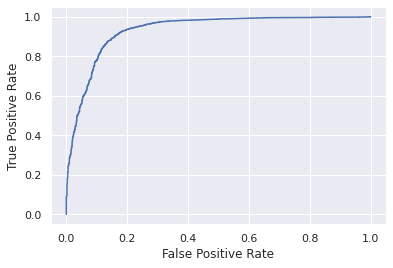

Final F1 score: 0.8284


In [21]:
# Training with best hyperparameters on the whole dataset

model = best_model_conf.create()
train(model, loader_X_train, best_training_conf, one_line_log=True)

# Save the model
torch.save(model.state_dict(), 'local_best_model.pt')

f1 = test(model, loader_X_test)
print(f"Final F1 score: {f1:.4f}")


# Model visualization

Finaly, we can try to at least partially understand the model by dissecting it.

DataBatch(x=[5507, 165], edge_index=[2, 6351], y=[5507], batch=[5507], ptr=[2])
DataBatch(x=[6393, 165], edge_index=[2, 7813], y=[6393], batch=[6393], ptr=[2])
DataBatch(x=[2314, 165], edge_index=[2, 2619], y=[2314], batch=[2314], ptr=[2])
DataBatch(x=[5063, 165], edge_index=[2, 5950], y=[5063], batch=[5063], ptr=[2])
DataBatch(x=[7140, 165], edge_index=[2, 8493], y=[7140], batch=[7140], ptr=[2])
DataBatch(x=[6621, 165], edge_index=[2, 8316], y=[6621], batch=[6621], ptr=[2])
DataBatch(x=[1653, 165], edge_index=[2, 1717], y=[1653], batch=[1653], ptr=[2])
DataBatch(x=[2816, 165], edge_index=[2, 3049], y=[2816], batch=[2816], ptr=[2])
DataBatch(x=[2047, 165], edge_index=[2, 2213], y=[2047], batch=[2047], ptr=[2])
DataBatch(x=[3506, 165], edge_index=[2, 3838], y=[3506], batch=[3506], ptr=[2])


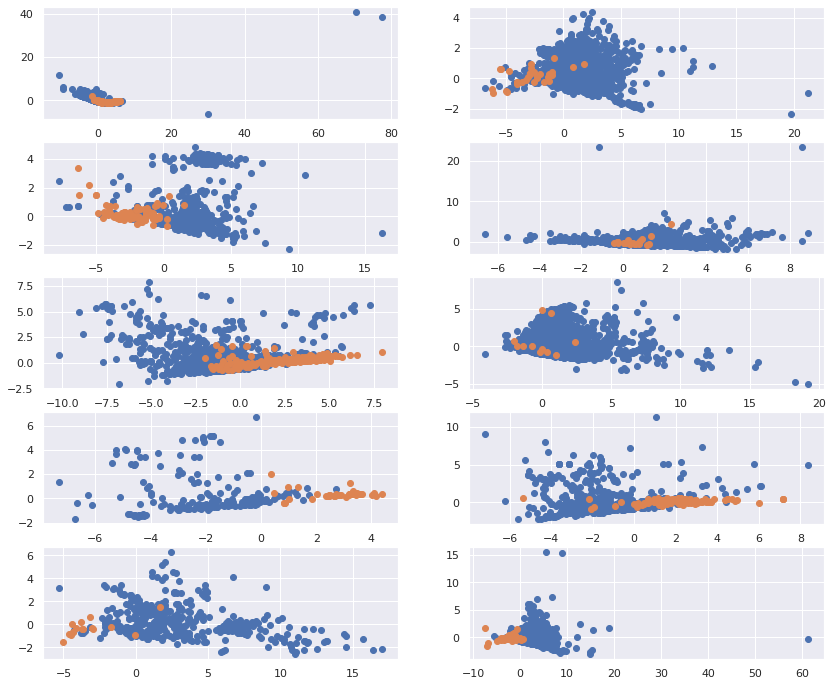

In [22]:
# Model visualization

from sklearn.decomposition import PCA

num_tests = len(loader_X_test)
plt.figure(figsize=(14, 12))

for i, data in enumerate(loader_X_test):
    data.to(device)
    out = model(data.x.float(), data.edge_index,
                return_embeddings=True).detach().cpu().numpy()
    plt.subplot(num_tests//2, 2, i+1)
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(out)

    print(data)
    idxLicit = (data.y == ID_LICIT).cpu().numpy()
    idxIlicit = (data.y == ID_ILLICIT).cpu().numpy()

    LicitPoints = pca_features[idxLicit]
    IlicitPoints = pca_features[idxIlicit]
    plt.scatter(LicitPoints[:, 0], LicitPoints[:, 1])
    plt.scatter(IlicitPoints[:, 0], IlicitPoints[:, 1])
plt.show()


# Model evaluation on a graph

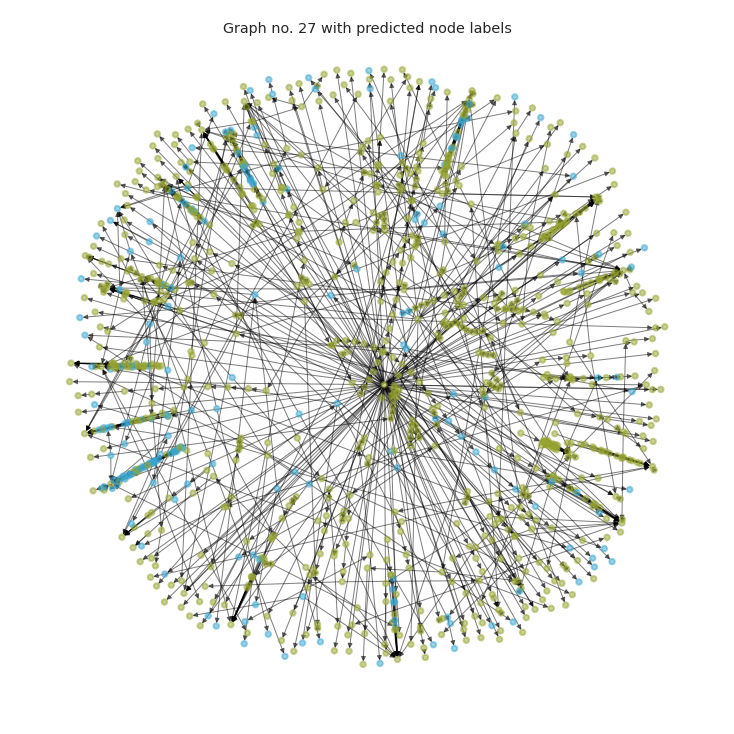

In [24]:
# Model evaluation on a single graph


def predict_node_class(batch, model):
    model.eval()
    with torch.no_grad():
        batch.to(device)
        out = model(batch.x.float(), batch.edge_index)
        return out.argmax(dim=1)

subgraph = dataset[min_idx]
batch = from_networkx(subgraph).to(device)
pred = predict_node_class(batch, model)

label_mask = (batch.y == ID_UNLABELED)
batch.y[label_mask] = pred[label_mask]

labels_dict = {}
for i,node in enumerate(subgraph.nodes()):
    labels_dict[node] = batch.y[i].item()

nx.set_node_attributes(subgraph, labels_dict, "new")
colors_full = [color_map[attrs["new"]] for _, attrs in smallest_subgraph.nodes(data=True)]

plt.figure(figsize=(10,10))

poz = nx.spring_layout(smallest_subgraph, center=None, dim=2, seed=1)
nx.draw(smallest_subgraph, node_color=colors_full, node_size=30, linewidths=2, edge_color="black", alpha=0.5, pos=poz)
plt.suptitle(f"Graph no. {min_idx+1} with predicted node labels")

pass